In [96]:
'''Measure the latency matrix in parallal'''

'Measure the latency matrix in parallal'

In [1]:
'''Deploy cross-node communication measuring pods'''

from kubernetes import client, config

def check_pods_existence(namespace):
    core_v1 = client.CoreV1Api()
    try:
        pods = core_v1.list_namespaced_pod(namespace=namespace)
        return len(pods.items) > 0 # return True
    except client.rest.ApiException as e:
        print(f"Exception when calling CoreV1Api->list_namespaced_pod: {e}")
        return False

def deploy_latency_measurement_daemonset_if_needed():
    namespace = 'measure-nodes'
    ds_name = 'latency-measurement-ds'
    
    # Assuming config and apps_v1 have been defined as before
    config.load_kube_config()
    apps_v1 = client.AppsV1Api()

    # Check if pods exist in the namespace
    pods_exist = check_pods_existence(namespace)

    # If no pods exist, deploy the DaemonSet
    if not pods_exist:
        # Define the body of the DaemonSet
        ds_body = client.V1DaemonSet(
            api_version="apps/v1",
            kind="DaemonSet",
            metadata=client.V1ObjectMeta(name=ds_name),
            spec=client.V1DaemonSetSpec(
                selector=client.V1LabelSelector(
                    match_labels={"app": "latency-measurement"}
                ),
                template=client.V1PodTemplateSpec(
                    metadata=client.V1ObjectMeta(labels={"app": "latency-measurement"}),
                    spec=client.V1PodSpec(
                        containers=[client.V1Container(
                            name="latency-container",
                            image="curlimages/curl",
                            security_context=client.V1SecurityContext(
                                capabilities=client.V1Capabilities(
                                    add=["NET_RAW"]  # Required for ping
                                )
                            )
                        )],
                        restart_policy="Always"
                    )
                )
            )
        )

        # Deploy the DaemonSet
        try:
            apps_v1.create_namespaced_daemon_set(namespace=namespace, body=ds_body)
            print(f"Deployed DaemonSet {ds_name} in namespace {namespace}")
        except client.rest.ApiException as e:
            print(f"Exception when calling AppsV1Api->create_namespaced_daemon_set: {e}")
    else:
        print("Pods already exist in the namespace. Skipping DaemonSet deployment.")

# Call the function to deploy the DaemonSet if needed
deploy_latency_measurement_daemonset_if_needed()



Pods already exist in the namespace. Skipping DaemonSet deployment.


In [4]:

'''As there are network jitter sometimes, means soemtimes sudden rise for a signle measurement:
To sovle this measuring issue:
(1) a easy and simple way to do is just the choose the lowest measured vaule to represent the latency 
between the measured node pair.
(2) another way, that can do is to meaured more vaules (like meaure 20 times), and use the 80% percentile as
the latency.

'''

from kubernetes import client, config, stream
import concurrent.futures

# Handle individual latency measurements between source and target pods.
def measure_latency_from_source_to_target(v1, namespace, source_pod, target_pod):
    source_pod_name = source_pod.metadata.name
    source_pod_node_name = source_pod.spec.node_name
    target_pod_ip = target_pod.status.pod_ip
    target_pod_name = target_pod.metadata.name
    target_pod_node_name = target_pod.spec.node_name
    result = (source_pod_node_name, target_pod_node_name, None)

    if source_pod_name != target_pod_name:
        exec_command = ['curl', '-o', '/dev/null', '-s', '-w', '%{time_total}', f'http://{target_pod_ip}']
        latencies = []
        for _ in range(5):
            try:
                resp = stream.stream(v1.connect_get_namespaced_pod_exec,
                                     source_pod_name,
                                     namespace,
                                     command=exec_command,
                                     stderr=True,
                                     stdin=False,
                                     stdout=True,
                                     tty=False)
                latency = float(resp) * 1000  # Convert the measured seconds into milliseconds
                latencies.append(latency)
            except Exception as e:
                print(f"Error executing command in pod {source_pod_name}: {e}")
        
        if latencies:
            min_latency = min(latencies) #choose the lowest measured vaule to represent the latency
            result = (source_pod_node_name, target_pod_node_name, min_latency)
            print(f"Latency from source node {source_pod_node_name} to target node {target_pod_node_name}: {min_latency} milliseconds")
        else:
            result = (source_pod_node_name, target_pod_node_name, "Error")

    return result

def measure_http_latency(namespace='measure-nodes'):
    v1 = client.CoreV1Api()
    pods = v1.list_namespaced_pod(namespace, label_selector="app=latency-measurement").items
    latency_results = {}
    
    # Run the latency measurement tasks concurrently
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for source_pod in pods:
            for target_pod in pods:
                futures.append(executor.submit(measure_latency_from_source_to_target, v1, namespace, source_pod, target_pod))
        
        # Aggregate the completed results into the latency_results dictionary
        for future in concurrent.futures.as_completed(futures):
            source_pod_node_name, target_pod_node_name, latency = future.result()
            if source_pod_node_name not in latency_results:
                latency_results[source_pod_node_name] = {}
            latency_results[source_pod_node_name][target_pod_node_name] = latency

    return latency_results

# Call the function to measure latency after deploying the DaemonSet
namespace = 'measure-nodes'
# After the DaemonSet is ready, and the related pods are ready
latency_results = measure_http_latency(namespace=namespace)
print(latency_results)


Latency from source node k8s-worker-9 to target node k8s-worker-8: 23.907999999999998 milliseconds
Latency from source node k8s-worker-9 to target node k8s-worker-7: 33.624 milliseconds
Latency from source node k8s-worker-6 to target node k8s-worker-7: 32.727 milliseconds
Latency from source node k8s-worker-6 to target node k8s-worker-5: 10.645 milliseconds
Latency from source node k8s-worker-3 to target node k8s-worker-1: 14.725 milliseconds
Latency from source node k8s-worker-9 to target node k8s-worker-5: 18.691 milliseconds
Latency from source node k8s-worker-6 to target node k8s-worker-1: 39.826 milliseconds
Latency from source node k8s-worker-7 to target node k8s-worker-8: 9.781 milliseconds
Latency from source node k8s-worker-3 to target node k8s-worker-4: 19.613 milliseconds
Latency from source node k8s-worker-7 to target node k8s-worker-6: 32.665 milliseconds
Latency from source node k8s-worker-6 to target node k8s-worker-8: 33.948 milliseconds
Latency from source node k8s-wor

In [5]:
import pandas as pd

# Convert the nested dictionary into a pandas DataFrame
df = pd.DataFrame(latency_results)

# Transpose the DataFrame to align the source and destination workers as per convention
df = df.T

# Fill diagonal with 0's for self-latency (optional, if desired for clarity)
for worker in df.columns:
    df.at[worker, worker] = 0

df

,k8s-worker-7,k8s-worker-8,k8s-worker-6,k8s-worker-9,k8s-worker-5,k8s-worker-1,k8s-worker-4,k8s-worker-3,k8s-worker-2
k8s-worker-7,0.000,9.781,32.665,33.623,41.602,65.444,59.624,67.627,68.487
k8s-worker-6,32.727,33.948,0.000,77.829,10.645,39.826,52.739,50.481,75.781
k8s-worker-9,33.624,23.908,77.820,0.000,18.691,178.630,68.597,56.564,107.593
k8s-worker-3,67.616,131.818,50.537,56.715,48.571,14.725,19.613,0.000,23.708
k8s-worker-5,41.716,46.918,10.590,18.646,0.000,94.586,16.806,48.499,46.648
k8s-worker-1,65.407,17.939,39.644,178.591,94.622,0.000,65.576,14.569,16.439
k8s-worker-2,68.506,99.902,75.701,107.500,46.544,16.434,22.570,23.609,0.000
k8s-worker-8,9.901,0.000,33.930,23.811,47.016,17.882,21.929,132.001,100.114
k8s-worker-4,59.663,22.106,52.781,68.731,16.644,65.676,0.000,19.583,22.554


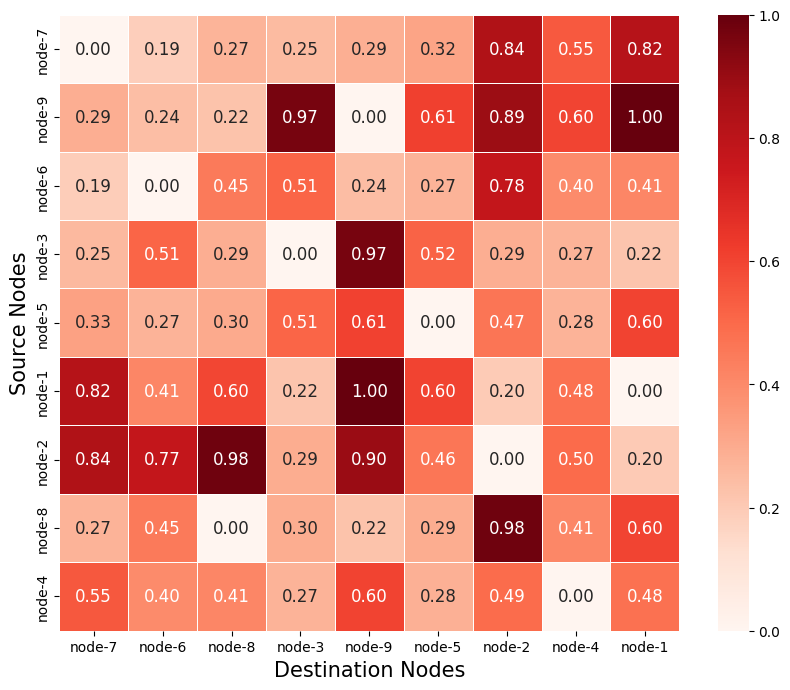

In [4]:
''' Normalize node-node communication delay matrix'''


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Convert the  dictionary into a pandas DataFrame and transpose it
df = pd.DataFrame(latency_results).T

# Mapping old names to new names
worker_node = {
    'k8s-worker-1': 'node-1', 'k8s-worker-2': 'node-2', 'k8s-worker-3': 'node-3',
    'k8s-worker-4': 'node-4', 'k8s-worker-5': 'node-5', 'k8s-worker-6': 'node-6',
    'k8s-worker-7': 'node-7', 'k8s-worker-8': 'node-8', 'k8s-worker-9': 'node-9'
}

# Rename the columns and index according to the dictionary
df.rename(columns=worker_node, index=worker_node, inplace=True)

# Fill diagonal with 0's for self-latency (optional, if desired for clarity)
for worker in df.columns:
    df.at[worker, worker] = 0

# Normalize the DataFrame
max_latency = df.max().max()  # Find the maximum value in the DataFrame
normalized_df = df / max_latency  # Divide every element by the maximum value

# Plot the normalized matrix
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_df, annot=True,  cmap= "Reds",fmt=".2f", annot_kws={'size': 12},xticklabels=True, yticklabels=True, linewidths=.5)
# plt.title('Normalized Latency Matrix')
plt.xlabel('Destination Nodes', fontsize=15)
plt.ylabel('Source Nodes', fontsize=15)
plt.show()


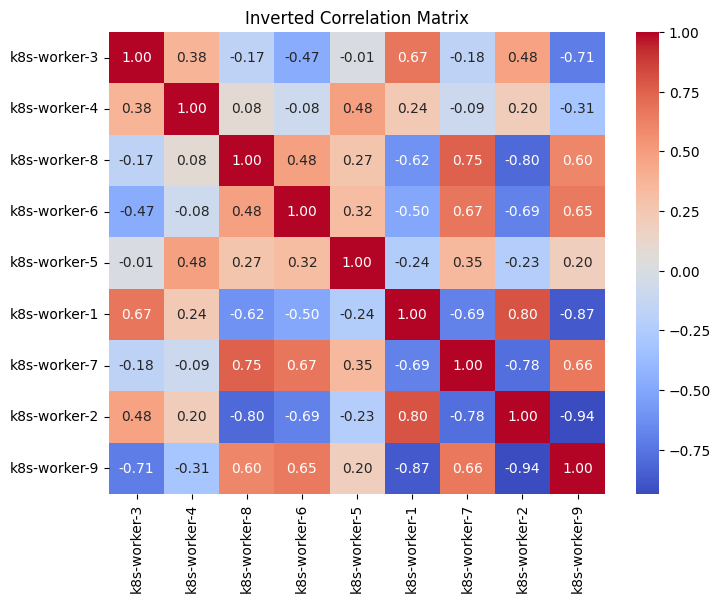

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# k8s-worker --- node
woker_node = {'k8s-worker-1': 'node1', 'k8s-worker-2': 'node2', 'k8s-worker-3': 'node3',
              'k8s-worker-4': 'node4', 'k8s-worker-5': 'node5', 'k8s-worker-6': 'node6',
              'k8s-worker-7': 'node7', 'k8s-worker-8': 'node8', 'k8s-worker-9': 'node9'}



df = pd.DataFrame(latency_results).T
for worker in df.columns:
    df.at[worker, worker] = 0

# Calculate the correlation matrix
corr_matrix = df.corr()

# Invert the correlation matrix
# inverted_corr_matrix =  np.abs(corr_matrix)

# Plot the inverted correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Inverted Correlation Matrix')
plt.show()



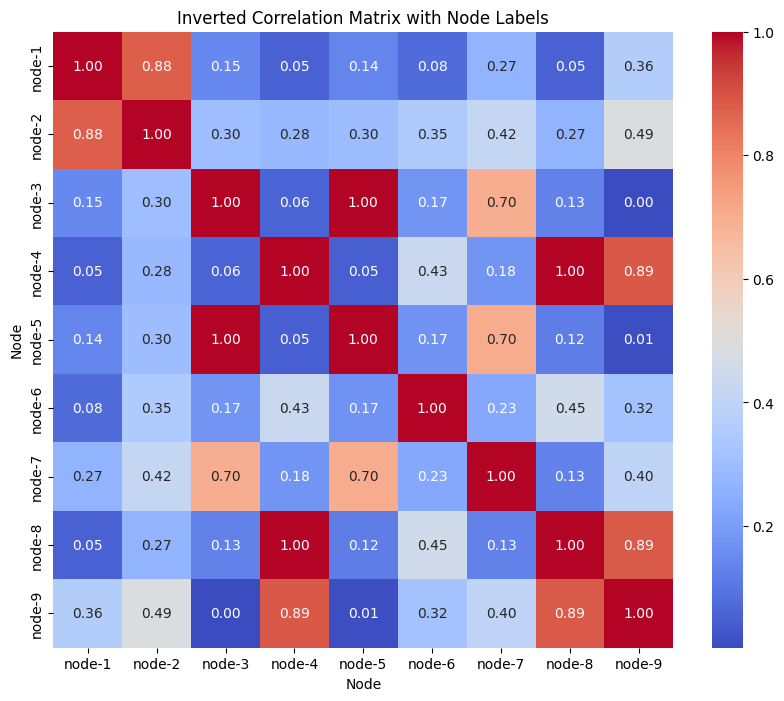

In [65]:
# Convert the nested dictionary into a pandas DataFrame and transpose it
df = pd.DataFrame(latency_results).T

# Fill diagonal with 0's for self-latency
for worker in df.columns:
    df.at[worker, worker] = 0

# Calculate the correlation matrix
corr_matrix = df.corr()

# Dictionary to map old worker names to new names
worker_node = {
    'k8s-worker-1': 'node-1', 'k8s-worker-2': 'node-2', 'k8s-worker-3': 'node-3',
    'k8s-worker-4': 'node-4', 'k8s-worker-5': 'node-5', 'k8s-worker-6': 'node-6',
    'k8s-worker-7': 'node-7', 'k8s-worker-8': 'node-8', 'k8s-worker-9': 'node-9'
}

# Rename the columns and index of the correlation matrix for visualization
renamed_corr_matrix = corr_matrix.rename(columns=worker_node, index=worker_node)

# Take the absolute value of the correlation matrix to invert it
inverted_renamed_corr_matrix = np.abs(renamed_corr_matrix)

# Plot the inverted correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(inverted_renamed_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=worker_node.values(), yticklabels=worker_node.values())
plt.title('Inverted Correlation Matrix with Node Labels')
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()